# Activity 1: Bias Analysis Using Fairness Metrics (PyTorch & TensorFlow)


In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [5]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

1. Load and Preprocess MNIST Dataset

In [6]:
# Load and normalize MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

In [7]:
# Split into training and testing sets
train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


2. Define & Train a Model on Unbiased Data

In [8]:
import torch.nn as nn
import torch.optim as optim

In [9]:
# Define MNIST model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
# Initialize model, loss function, optimizer
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Train the model
for epoch in range(1, 6):
  train_loss = 0.0
  total_samples = 0

  for batch_idx, (images, labels) in enumerate(train_loader, start=1):
      num = images.size(0)
      total_samples += num

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * num

  avg_loss = train_loss / total_samples
  print(f"Epoch {epoch} completed. Average Loss: {avg_loss:.4f}")  # Debugging loss

3. Introduce Bias by Removing Digit '1'

In [12]:
# Remove all samples where label is '1'
biased_dataset = [sample for sample in train_dataset if sample[1] != 1]
biased_train_loader = DataLoader(biased_dataset, batch_size=32, shuffle=True)

4. Compute Fairness Metrics

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score


In [14]:
def demographic_parity(y_true, y_pred):
    unique, counts = np.unique(y_pred, return_counts=True)
    return dict(zip(unique, counts))

def equal_opportunity(y_true, y_pred, target_class=1):
    idx = np.where(np.array(y_true) == target_class)
    predictions = np.array(y_pred)[idx]
    unique, counts = np.unique(predictions, return_counts=True)
    return dict(zip(unique, counts))

In [15]:
# Evaluate unbiased model
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

dp_unbiased = demographic_parity(y_true, y_pred)
eo_unbiased = equal_opportunity(y_true, y_pred)

print("Demographic Parity (Unbiased):", dp_unbiased)
print("Equal Opportunity (Unbiased):", eo_unbiased)

Demographic Parity (Unbiased): {np.int64(0): np.int64(1150), np.int64(1): np.int64(1385), np.int64(2): np.int64(1293), np.int64(3): np.int64(1152), np.int64(4): np.int64(1148), np.int64(5): np.int64(1095), np.int64(6): np.int64(1239), np.int64(7): np.int64(1233), np.int64(8): np.int64(1138), np.int64(9): np.int64(1167)}
Equal Opportunity (Unbiased): {np.int64(1): np.int64(1325), np.int64(2): np.int64(7), np.int64(3): np.int64(3), np.int64(5): np.int64(3), np.int64(6): np.int64(1), np.int64(7): np.int64(1), np.int64(8): np.int64(16), np.int64(9): np.int64(2)}


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

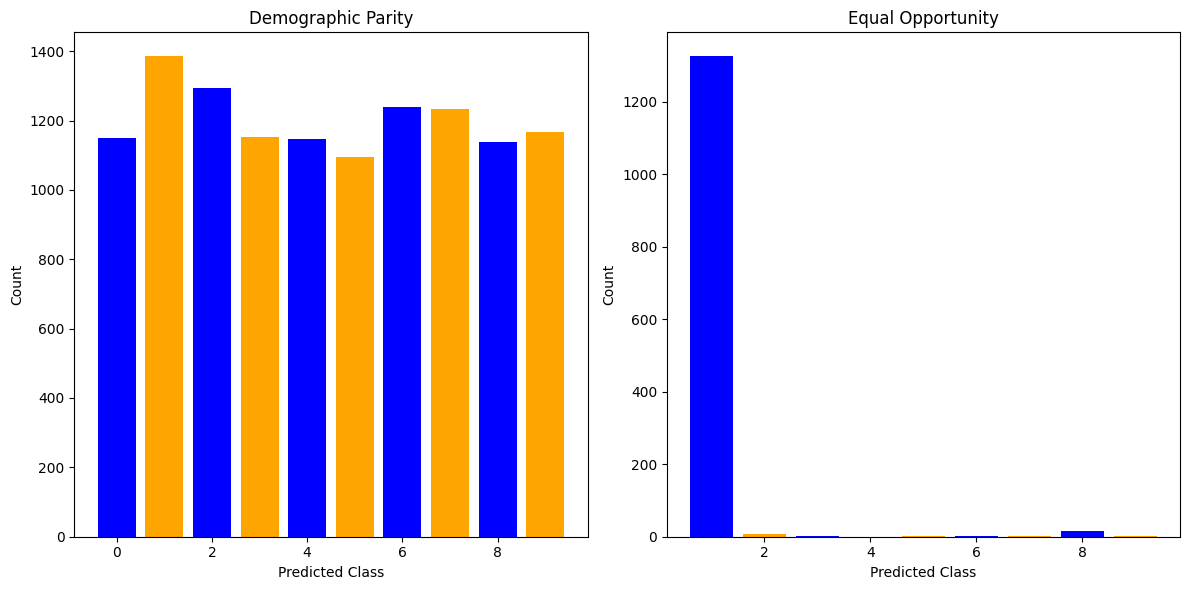

In [17]:
# Fairness analysis visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Demographic Parity
dp_labels, dp_counts = zip(*dp_unbiased.items())
ax[0].bar(dp_labels, dp_counts, color=['blue', 'orange'])
ax[0].set_title("Demographic Parity")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Predicted Class")

# Plot Equal Opportunity
eo_labels, eo_counts = zip(*eo_unbiased.items())
ax[1].bar(eo_labels, eo_counts, color=['blue', 'orange'])
ax[1].set_title("Equal Opportunity")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Predicted Class")

plt.tight_layout()
plt.show()

Activity 2: Visualization of Bias Effects on Model Performance

1. Train a New Model on Biased Data

In [18]:
# Train a new model using biased dataset
biased_model = MNISTModel()
optimizer = optim.SGD(biased_model.parameters(), lr=0.01)

for epoch in range(5):
    for images, labels in biased_train_loader:
        optimizer.zero_grad()
        outputs = biased_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


2.  Evaluate the Biased Model

In [19]:
# Evaluate the biased model
y_true_biased, y_pred_biased = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = biased_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_biased.extend(labels.numpy())
        y_pred_biased.extend(predicted.numpy())

dp_biased = demographic_parity(y_true_biased, y_pred_biased)
eo_biased = equal_opportunity(y_true_biased, y_pred_biased)

print("Demographic Parity (Biased):", dp_biased)
print("Equal Opportunity (Biased):", eo_biased)


Demographic Parity (Biased): {np.int64(0): np.int64(1130), np.int64(2): np.int64(1360), np.int64(3): np.int64(1583), np.int64(4): np.int64(1225), np.int64(5): np.int64(1228), np.int64(6): np.int64(1236), np.int64(7): np.int64(1475), np.int64(8): np.int64(1615), np.int64(9): np.int64(1148)}
Equal Opportunity (Biased): {np.int64(2): np.int64(172), np.int64(3): np.int64(362), np.int64(5): np.int64(73), np.int64(6): np.int64(5), np.int64(7): np.int64(200), np.int64(8): np.int64(542), np.int64(9): np.int64(4)}


3. Plot Performance Drop Due to Bias

In [21]:
!pip install seaborn

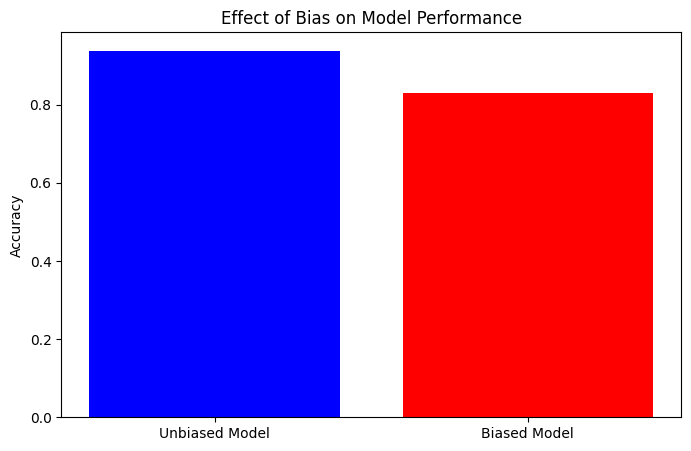

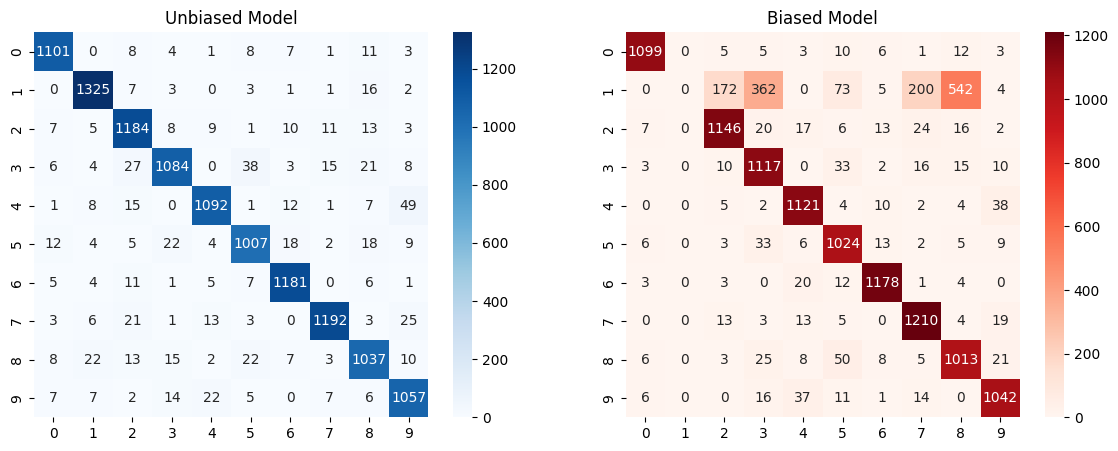

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute accuracy
accuracy_unbiased = accuracy_score(y_true, y_pred)
accuracy_biased = accuracy_score(y_true_biased, y_pred_biased)

# Plot accuracy drop
plt.figure(figsize=(8,5))
plt.bar(['Unbiased Model', 'Biased Model'], [accuracy_unbiased, accuracy_biased], color=['blue', 'red'])
plt.ylabel("Accuracy")
plt.title("Effect of Bias on Model Performance")
plt.show()

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Unbiased Model")
sns.heatmap(confusion_matrix(y_true_biased, y_pred_biased), annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title("Biased Model")
plt.show()


Activity 3: Federated Learning

In [13]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define PyTorch Federated Learning Client
class PyTorchFederatedClient(fl.client.NumPyClient):
    def __init__(self, model, train_data):
        self.model = model
        self.train_data = train_data
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.CrossEntropyLoss()

    def get_parameters(self):
        return [p.detach().numpy() for p in self.model.parameters()]

    def set_parameters(self, parameters):
        for param, new_param in zip(self.model.parameters(), parameters):
            param.data = torch.tensor(new_param)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=32, shuffle=True)
        self.model.train()
        for epoch in range(1):  # Adjust epochs as needed
            for data, target in train_loader:
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
        return self.get_parameters(), len(self.train_data), {}

# Configure and start federated learning server
fl.server.start_server(config={"num_rounds": 5}, server_address="localhost:8080")

TypeError: start_server() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given